# Churn Training Pipeline

By using XGBoost model, we are going to train our model.

1. Select the features you want to train the model on.
2. Preprocess of features.
3. Create a dataset split for training and validation data.
4. Load the training data.
5. Train the model.
6. Explore feature groups and views via the UI.

In [1]:
import os
from PIL import Image

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
import xgboost as xgb

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Connecting to Hopsworks Feature Store

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1133716
2024-10-25 08:23:34,004 WARNING: using legacy validation callback
Connected. Call `.close()` to terminate connection gracefully.


### Feature Selection

In [3]:
# Retrieve feature groups
customer_info_fg = fs.get_feature_group(
    name="customer_info",
    version=1,
)

demography_fg = fs.get_feature_group(
    name="customer_demography_info",
    version=1,
)

subscriptions_fg = fs.get_feature_group(
    name="customer_subscription_info",
    version=1,
)

In [4]:
# Select features for training data
selected_features = customer_info_fg.select_except(["customerid", "datetime"]) \
    .join(demography_fg.select_except(["customerid"])) \
    .join(subscriptions_fg.select_except(["datatime"]))

selected_features.show(5)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.85s) 


,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,churn,gender,seniorcitizen,dependents,...,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv,datetime
0,Month-to-month,59,Electronic check,Yes,89.75,5496.90,0,Female,1,No,...,Yes,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,2021-12-24 02:39:30.008520+00:00
1,Month-to-month,1,Electronic check,Yes,93.55,93.55,1,Male,1,No,...,No,No,No,Fiber optic,Yes,Yes,No,Yes,Yes,2020-06-14 23:38:56.268105+00:00
2,Month-to-month,38,Mailed check,Yes,81.85,3141.70,0,Male,0,Yes,...,No,Yes,No,Fiber optic,Yes,Yes,No,No,No,2021-01-02 06:21:09.866515+00:00
3,Two year,64,Bank transfer (automatic),No,110.30,6997.30,0,Female,0,Yes,...,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,2020-08-15 00:33:19.886395+00:00
4,Month-to-month,24,Bank transfer (automatic),Yes,49.55,1210.40,1,Male,0,No,...,No,No,Yes,DSL,No,Yes,No,No,No,2020-04-17 13:01:33.041749+00:00


### Transformation Functions

We will be using min-max scaling on numerical features and label encoding on categorical features.

In [5]:
# Load transformation functions from the feature store
min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
label_encoder = fs.get_transformation_function(name="label_encoder")

# Define lists of numerical and categorical features
numerical_features = ["tenure", "monthlycharges", "totalcharges"]
categorical_features = [
    "multiplelines", "internetservice", "onlinesecurity", "onlinebackup",
    "deviceprotection", "techsupport", "streamingmovies", "streamingtv",
    "phoneservice", "paperlessbilling", "contract", "paymentmethod", "gender", 
    "dependents", "partner",
]

# Map features to their corresponding transformation functions
transformation_functions = {}

# For numerical features, use the min_max_scaler transformation
for feature in numerical_features:
    transformation_functions[feature] = min_max_scaler

# For categorical features, use the label_encoder transformation
for feature in categorical_features:
    transformation_functions[feature] = label_encoder

In [6]:
numerical_features

['tenure', 'monthlycharges', 'totalcharges']

In [7]:
categorical_features

['multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingmovies',
 'streamingtv',
 'phoneservice',
 'paperlessbilling',
 'contract',
 'paymentmethod',
 'gender',
 'dependents',
 'partner']

### Feature View Creation

In [8]:
# Get or create the 'churn_feature_view'
feature_view = fs.get_or_create_feature_view(
        name = 'churn_feature_view',
        version = 2,
        labels=["churn"],
        transformation_functions=transformation_functions,
        query=selected_features,
)

### Training Dataset

In [9]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

# Ensure correct data types for XGBoost
for col in numerical_features:
    X_train[col] = X_train[col].astype(int)
    X_val[col] = X_val[col].astype(int)
    X_test[col] = X_test[col].astype(int)

for col in categorical_features:
    X_train[col] = X_train[col].astype("category").cat.codes
    X_val[col] = X_val[col].astype("category").cat.codes
    X_test[col] = X_test[col].astype("category").cat.codes

# Drop the 'customerid' column from the training set
X_train.drop('customerid', axis=1, inplace=True)

# Drop the 'customerid' column from the validation set
X_val.drop('customerid', axis=1, inplace=True)

# Drop the 'customerid' column from the test set
X_test.drop('customerid', axis=1, inplace=True)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.24s) 
2024-10-25 08:25:12,694 WARNING: VersionWarning: Incremented version to `6`.



In [10]:
X_train.head(3)

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv,datetime
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2021-12-24 02:39:30.008520+00:00
1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,1,1,2020-06-14 23:38:56.268105+00:00
2,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,2021-01-02 06:21:09.866515+00:00


In [11]:
X_test.head(3)

,contract,tenure,paymentmethod,paperlessbilling,monthlycharges,totalcharges,gender,seniorcitizen,dependents,partner,deviceprotection,onlinebackup,onlinesecurity,internetservice,multiplelines,phoneservice,techsupport,streamingmovies,streamingtv,datetime
3,2,0,2,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,2020-08-15 00:33:19.886395+00:00
32,1,0,1,1,0,0,1,0,0,1,1,1,0,1,0,0,1,1,1,2021-06-18 21:51:47.185458+00:00
42,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,2020-04-13 01:53:53.967622+00:00


In [12]:
y_train.head(3)

,churn
0,0
1,1
2,0


In [13]:
# Display the normalized value counts of the target variable
y_train.value_counts(normalize=True)

churn
0        0.737728
1        0.262272
Name: proportion, dtype: float64

The distribution is skewed, which is good news for the company considering that customers at risk of churning make up smaller part of customer base

### Train Model

Train a model and set the bigger class weight for the positive class.

In [14]:
# Drop the 'datetime' column
X_train = X_train.drop(columns=['datetime'])
X_test = X_test.drop(columns=['datetime'])

# Verify the column has been removed
print(X_train.dtypes)


contract             int8
tenure              int32
paymentmethod        int8
paperlessbilling     int8
monthlycharges      int32
totalcharges        int32
gender               int8
seniorcitizen       int64
dependents           int8
partner              int8
deviceprotection     int8
onlinebackup         int8
onlinesecurity       int8
internetservice      int8
multiplelines        int8
phoneservice         int8
techsupport          int8
streamingmovies      int8
streamingtv          int8
dtype: object


In [15]:
print(X_train.shape)  # Should be (n_samples, n_features)
print(y_train.shape)  # Should be (n_samples,)

(4930, 19)
(4930, 1)


In [16]:
print(y_train.head())

   churn
0      0
1      1
2      0
4      1
5      0


In [17]:
print(X_train.isnull().sum())  # Check for NaN values in features
print(y_train.isnull().sum())   # Check for NaN values in labels

contract            0
tenure              0
paymentmethod       0
paperlessbilling    0
monthlycharges      0
totalcharges        0
gender              0
seniorcitizen       0
dependents          0
partner             0
deviceprotection    0
onlinebackup        0
onlinesecurity      0
internetservice     0
multiplelines       0
phoneservice        0
techsupport         0
streamingmovies     0
streamingtv         0
dtype: int64
churn    0
dtype: int64


In [18]:
# Create an instance of the XGBClassifier with a specified scale_pos_weight
model = xgb.XGBClassifier(scale_pos_weight=3)

# Fit the classifier on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Model Evaluation

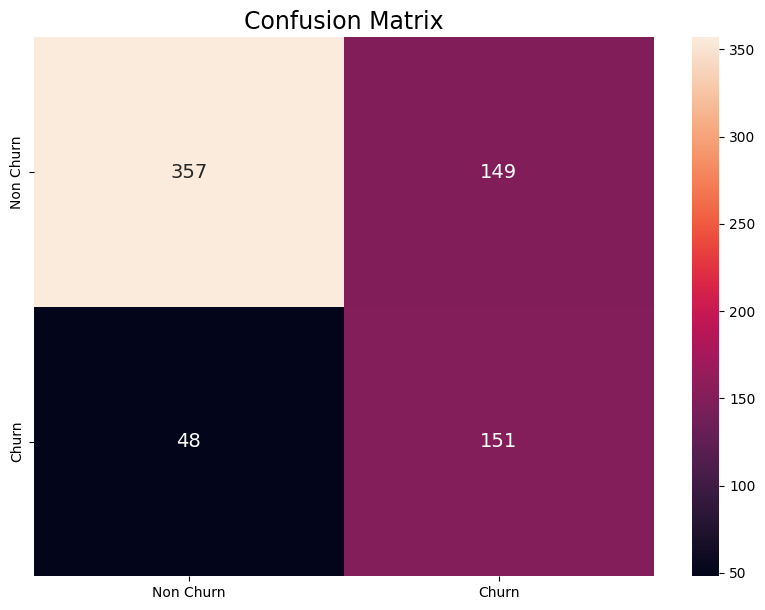

In [19]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels from the classifier
conf_matrix = confusion_matrix(
    y_test, 
    model.predict(X_test),
).astype(int)

# Create a DataFrame from the confusion matrix results with appropriate labels
df_cm = pd.DataFrame(
    conf_matrix, 
    ['Non Churn', 'Churn'],
    ['Non Churn', 'Churn'],
)

# Create a heatmap using seaborn with annotations
figure_cm = plt.figure(figsize=(10, 7))
figure_cm = sns.heatmap(
    df_cm, 
    annot=True, 
    annot_kws={"size": 14}, 
    fmt='.10g',
)

# Set the title for the confusion matrix plot
plt.title('Confusion Matrix', fontsize=17)

# Display the plot
plt.show()

### Model Registry

In [20]:
# Get the model registry
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


### Model Schema

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Create input schema using X_train
input_schema = Schema(X_train)

# Create output schema using y_train
output_schema = Schema(y_train)

# Create a ModelSchema object specifying the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the model schema to a dictionary
model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'contract', 'type': 'int8'},
   {'name': 'tenure', 'type': 'int32'},
   {'name': 'paymentmethod', 'type': 'int8'},
   {'name': 'paperlessbilling', 'type': 'int8'},
   {'name': 'monthlycharges', 'type': 'int32'},
   {'name': 'totalcharges', 'type': 'int32'},
   {'name': 'gender', 'type': 'int8'},
   {'name': 'seniorcitizen', 'type': 'int64'},
   {'name': 'dependents', 'type': 'int8'},
   {'name': 'partner', 'type': 'int8'},
   {'name': 'deviceprotection', 'type': 'int8'},
   {'name': 'onlinebackup', 'type': 'int8'},
   {'name': 'onlinesecurity', 'type': 'int8'},
   {'name': 'internetservice', 'type': 'int8'},
   {'name': 'multiplelines', 'type': 'int8'},
   {'name': 'phoneservice', 'type': 'int8'},
   {'name': 'techsupport', 'type': 'int8'},
   {'name': 'streamingmovies', 'type': 'int8'},
   {'name': 'streamingtv', 'type': 'int8'}]},
 'output_schema': {'columnar_schema': [{'name': 'churn', 'type': 'int64'}]}}

In [22]:
# Specify the directory where the model files will be saved
model_dir = "churn_model_v2"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained classifier as json file
model.save_model(model_dir + "/model_v2.json")

# Save the confusion matrix heatmap as an image in the model directory
figure_cm.figure.savefig(model_dir + '/confusion_matrix_v2.png')

In [23]:
# Create a model in the model registry
model = mr.python.create_model(
    name="churnmodelv2",
    description="Churn Model Version 2",
    input_example=X_train.sample(),
    model_schema=model_schema,
)

# Save the model to the specified directory
model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/22366 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/589977 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/57 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1636 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1133716/models/churnmodelv2/1


Model(name: 'churnmodelv2', version: 1)